## Descarga Dataset

In [ ]:
import kagglehub
import os
import shutil

In [ ]:
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")
print("Path to dataset files:", path)

In [9]:
dir_act = os.getcwd()
for item in os.listdir(path):
    src = os.path.join(path, item)
    dst = os.path.join(dir_act, item)
    shutil.move(src, dst)

## Preparacion del entorno

In [ ]:
# Librerías estándar
import os
import json
from collections import Counter
from pathlib import Path
import pickle

# Numpy y Pandas
import numpy as np
import pandas as pd

# PIL / imagen
from PIL import Image, ImageDraw, ImageFont

# Matplotlib
import matplotlib.pyplot as plt

# tqdm (barra de progreso)
from tqdm import tqdm

# PyTorch y torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Model

# ONNX y ONNX Runtime
import onnx
import onnxruntime as ort

# FAISS
import faiss

# pycocotools (COCO eval y manejo)
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Ultralytics YOLO (detección)
from ultralytics import YOLO

# Gradio (interfaz)
import gradio as gr

/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-28 14:46:09.196736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751132769.249017   28154 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751132769.264771   28154 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751132769.372105   28154 computation_placer.cc:177] computation placer already registered. Please check linkage and a

In [2]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2025-06-28 14:46:11.913206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751132771.930770   28191 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751132771.936780   28191 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751132771.950997   28191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751132771.951018   28191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751132771.951022   28191 computation_placer.cc:177] computation placer alr

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Etapa 1: Buscador de Imágenes por Similitud

### Creación de la Base de Datos Vectorial:

#### Modelo base

In [7]:
# Cargar el CSV
df_dogs_breed = pd.read_csv("dogs.csv")

# Asegurar que las rutas sean correctas y completas
df_dogs_breed['full_path'] = df_dogs_breed['filepaths'].apply(lambda x: os.path.join(os.getcwd(), x))

# Filtrar solo imágenes existentes por seguridad
df_dogs_breed = df_dogs_breed[df_dogs_breed['full_path'].apply(os.path.exists)].reset_index(drop=True)

In [8]:
df_dogs_breed

filepaths  labels data set  \
0     train/Afghan/001.jpg  Afghan    train   
1     train/Afghan/002.jpg  Afghan    train   
2     train/Afghan/003.jpg  Afghan    train   
3     train/Afghan/004.jpg  Afghan    train   
4     train/Afghan/005.jpg  Afghan    train   
...                    ...     ...      ...   
9341   valid/Yorkie/06.jpg  Yorkie    valid   
9342   valid/Yorkie/07.jpg  Yorkie    valid   
9343   valid/Yorkie/08.jpg  Yorkie    valid   
9344   valid/Yorkie/09.jpg  Yorkie    valid   
9345   valid/Yorkie/10.jpg  Yorkie    valid   

                                              full_path  
0     /home/franco/Escritorio/TUIA/Computer Vision/C...  
1     /home/franco/Escritorio/TUIA/Computer Vision/C...  
2     /home/franco/Escritorio/TUIA/Computer Vision/C...  
3     /home/franco/Escritorio/TUIA/Computer Vision/C...  
4     /home/franco/Escritorio/TUIA/Computer Vision/C...  
...                                                 ...  
9341  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9342  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9343  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9344  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9345  /home/franco/Escritorio/TUIA/Computer Vision/C...  

[9346 rows x 4 columns]

In [9]:
# Crear modelo de embeddings (sin capa de clasificación final)
model_RN50 = ResNet50(weights='imagenet', include_top=False, pooling='avg')

I0000 00:00:1751132786.697910   28154 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7948 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:08:00.0, compute capability: 8.6


In [10]:
def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model_RN50.predict(x, verbose=0)[0]

#### Embeddings

In [8]:
# Obtener embeddings
embeddings = []
for path in tqdm(df_dogs_breed['full_path'], desc="Extrayendo embeddings"):
    try:
        embeddings.append(get_embedding(path))
    except Exception as e:
        print(f"Error en {path}: {e}")

Extrayendo embeddings:   0%|          | 0/9346 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1751036645.877657    5240 service.cc:152] XLA service 0x7d593c0024d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751036645.877676    5240 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-27 12:04:05.955411: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751036646.387333    5240 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1751036647.877333    5240 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extrayendo embeddings: 100%|██████████| 9346/9346 [08:55<00:00, 17.47it/s]


In [9]:
embedding_matrix = np.array(embeddings).astype("float32")
index = faiss.IndexFlatL2(embedding_matrix.shape[1])
index.add(embedding_matrix)
with open("embedding_matrix.pkl", "wb") as f:
    pickle.dump(embedding_matrix, f)

#### Gradio

In [4]:
with open("embedding_matrix.pkl", "rb") as f:
    embedding_matrix = pickle.load(f)
index = faiss.IndexFlatL2(embedding_matrix.shape[1])
index.add(embedding_matrix) 
# Cargar el CSV
df_dogs_breed = pd.read_csv("dogs.csv")
# Asegurar que las rutas sean correctas y completas
df_dogs_breed['full_path'] = df_dogs_breed['filepaths'].apply(lambda x: os.path.join(os.getcwd(), x))
# Filtrar solo imágenes existentes por seguridad
df_dogs_breed = df_dogs_breed[df_dogs_breed['full_path'].apply(os.path.exists)].reset_index(drop=True)

In [5]:
def search_similar_images(query_path, k=10):
    vec = get_embedding(query_path).astype("float32").reshape(1, -1)
    distances, indices = index.search(vec, k + 1)  # Pedimos uno más
    indices = indices[0][1:]  # Saltamos el primero (la imagen idéntica)
    return df_dogs_breed.iloc[indices]

I0000 00:00:1751132795.426778   28251 service.cc:152] XLA service 0x72cab0048f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751132795.426797   28251 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-28 14:46:35.504558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751132795.939255   28251 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1751132797.419248   28251 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


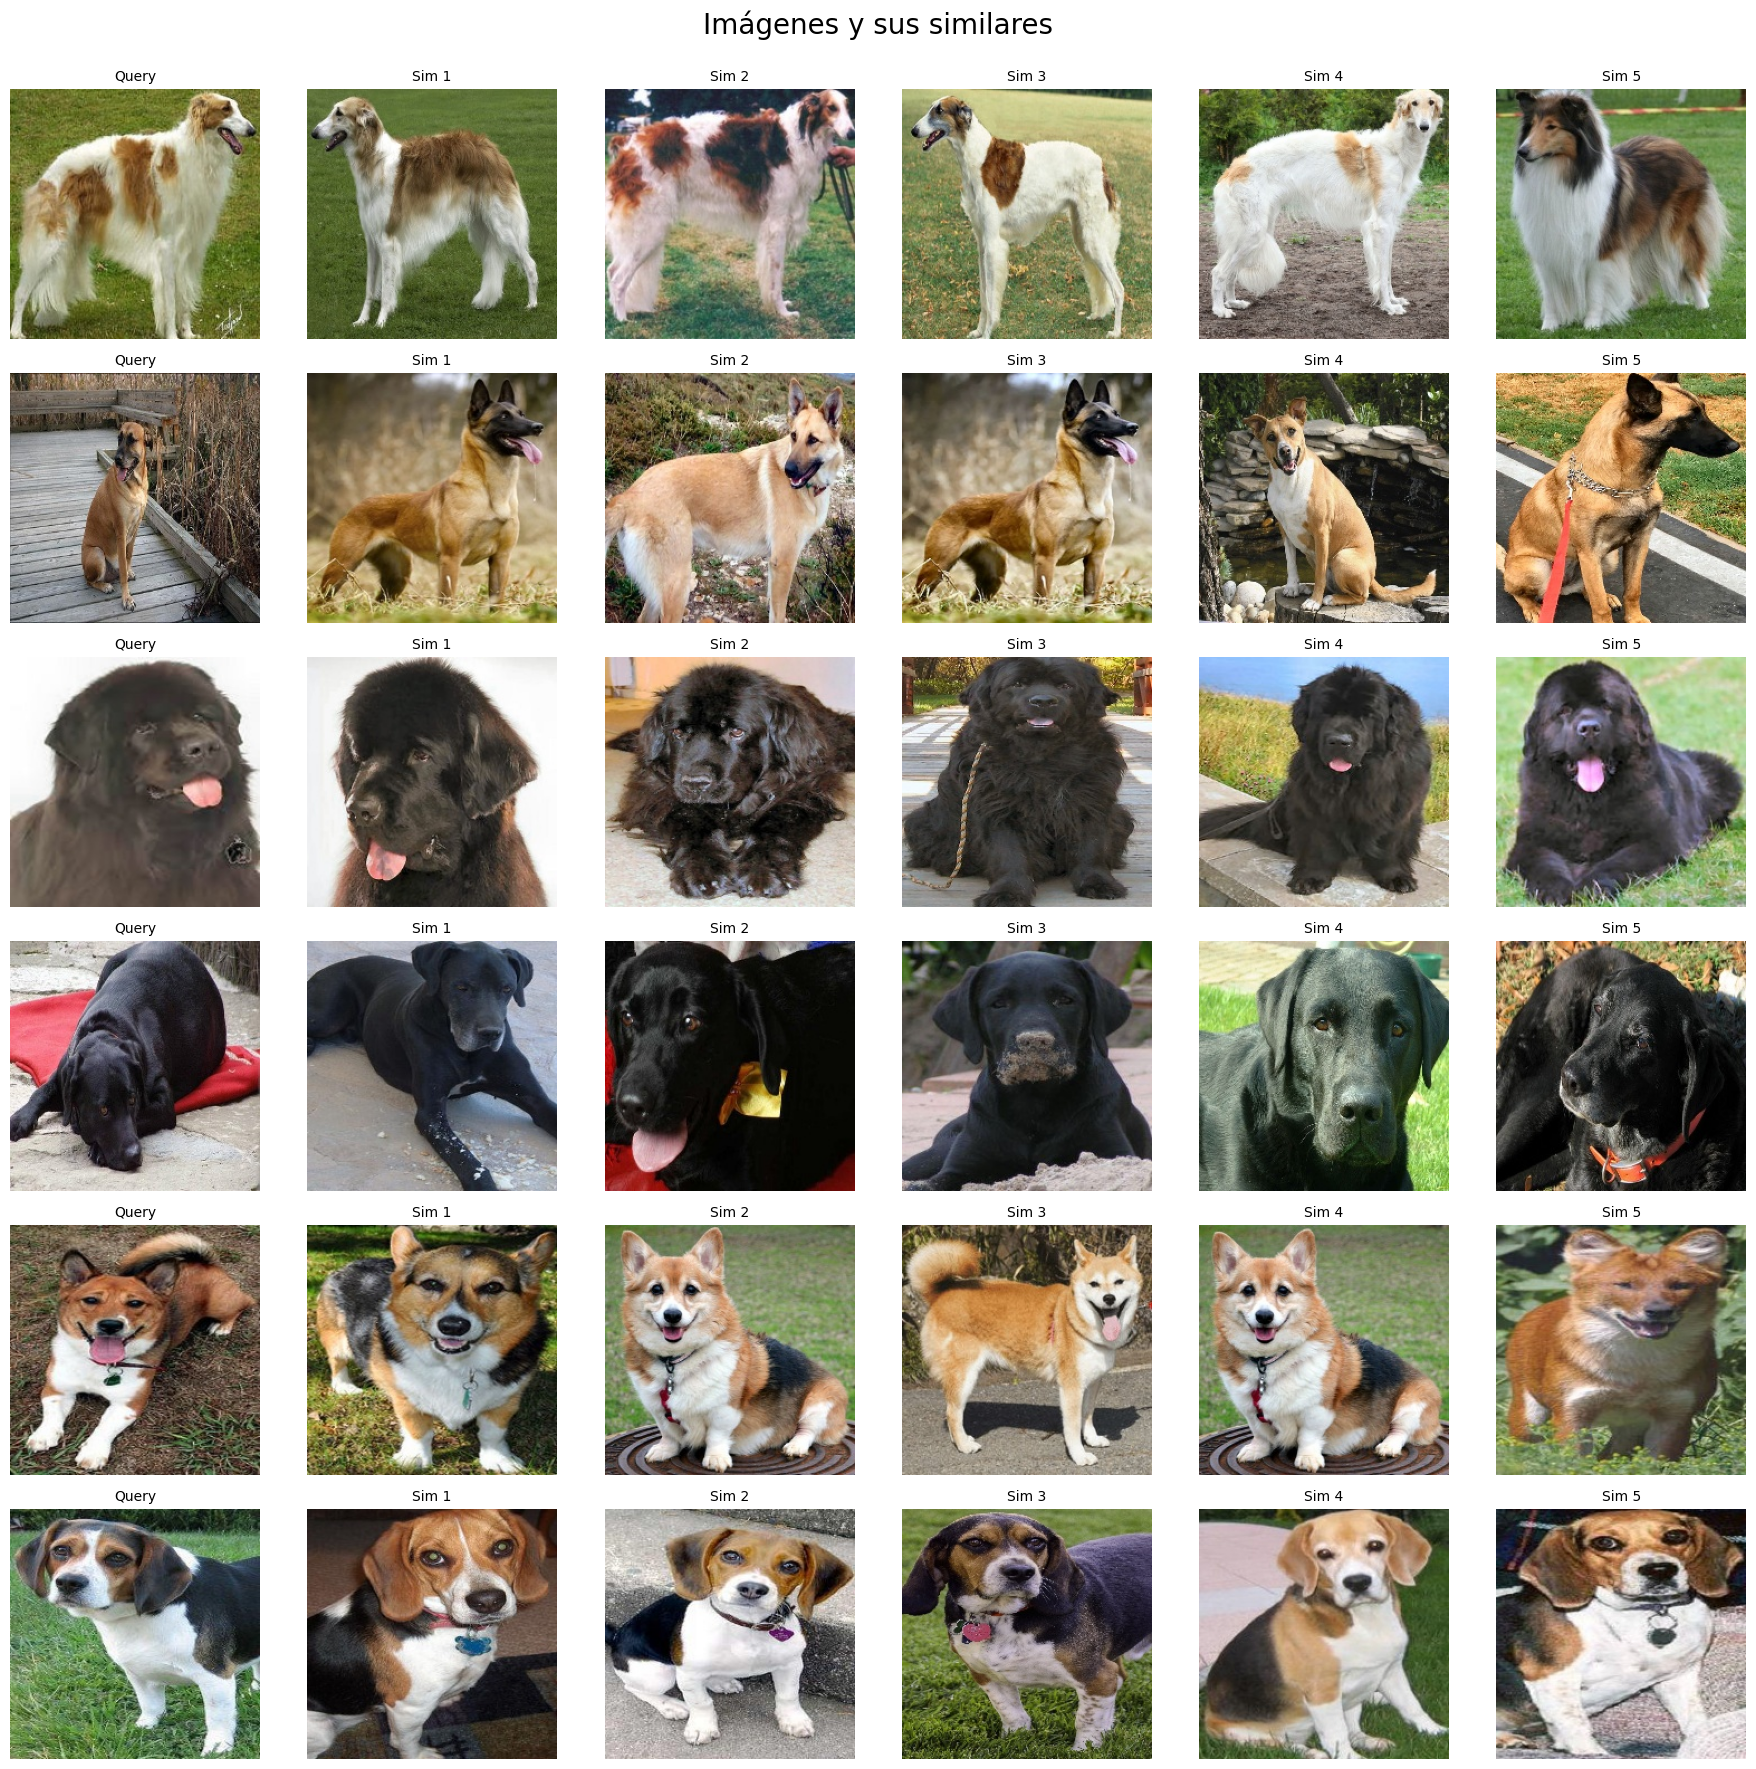

In [11]:
# Elegimos 6 muestras aleatorias
samples = df_dogs_breed.sample(6).reset_index(drop=True)

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 18))
fig.suptitle("Imágenes y sus similares", fontsize=20)

for i in range(6):
    # Imagen consulta
    query_path = samples.iloc[i]['full_path']
    similar_df = search_similar_images(query_path, k=5)

    # Mostrar imagen original
    img = plt.imread(query_path)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Query", fontsize=10)
    axes[i, 0].axis('off')

    # Mostrar similares
    for j in range(5):
        sim_path = similar_df.iloc[j]['full_path']
        sim_img = plt.imread(sim_path)
        axes[i, j+1].imshow(sim_img)
        axes[i, j+1].set_title(f"Sim {j+1}", fontsize=10)
        axes[i, j+1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Desarrollo de la Aplicación en Gradio:

In [12]:
def show_similar_images(uploaded_image):
    # Guardar la imagen temporalmente
    temp_path = "temp_input.jpg"
    uploaded_image.save(temp_path)

    # Obtener imágenes similares
    similares_df = search_similar_images(temp_path, k=10)

    # Convertir las rutas a objetos PIL.Image
    resultado_imagenes = [Image.open(fp) for fp in similares_df['full_path'].values]

    # Devolver imagen original + resultados
    return [uploaded_image] + resultado_imagenes

In [ ]:
gr.Interface(
    fn=show_similar_images,
    inputs=gr.Image(type="pil", label="Subí una imagen de perro"),
    outputs=[gr.Image(label="Imagen subida")] + [gr.Image(label=f"Similar {i+1}") for i in range(10)],
    title="Buscador de Razas de Perros",
    description="Subí una imagen de un perro y encontrá las 10 imágenes más similares del dataset."
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio/flagged/dataset1.csv


### Clasificación Basada en Similitud y Métrica de Evaluación

In [14]:
def predict_breed_by_majority(query_path, k=10):
    similar_images = search_similar_images(query_path, k)
    predicted_breed = Counter(similar_images['labels']).most_common(1)[0][0]
    return predicted_breed, similar_images

In [15]:
def gradio_interface(img):
    # Guardar imagen temporal para procesar
    temp_path = "temp_input.jpg"
    img.save(temp_path)

    # Predicción
    predicted_breed, similar_df = predict_breed_by_majority(temp_path, k=10)

    # Mostrar imágenes similares
    similar_paths = similar_df['full_path'].tolist()
    similar_imgs = [Image.open(p) for p in similar_paths]

    return predicted_breed, [img] + similar_imgs  # Input + similares

In [18]:
# Definimos interfaz
gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="Raza Predicha"),
        gr.Gallery(label="Imagen de Entrada + 10 Similares", columns=5, height=400)
    ],
    title="Clasificador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro y encuentra las 10 más parecidas del dataset.",
    
).launch(share=True)  # Cambiado a True para compartir la interfaz

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://ad14811781af99d948.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [18]:
def dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

In [19]:
def ndcg_at_k(true_label, retrieved_labels, k=10):
    relevances = [1 if label == true_label else 0 for label in retrieved_labels[:k]]
    ideal_relevances = sorted(relevances, reverse=True)
    dcg_val = dcg(relevances)
    idcg_val = dcg(ideal_relevances)
    return dcg_val / idcg_val if idcg_val > 0 else 0.0

In [20]:
ndcg_scores = []
test_df = df_dogs_breed[df_dogs_breed['data set'] == 'test']
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    query_path = row['full_path']
    true_label = row['labels']
    
    similar_images = search_similar_images(query_path, k=10)
    retrieved_labels = similar_images['labels'].tolist()
    
    score = ndcg_at_k(true_label, retrieved_labels, k=10)
    ndcg_scores.append(score)

average_ndcg = np.mean(ndcg_scores)
print(f"NDCG@10 promedio en el set de prueba: {average_ndcg:.4f}")

100%|██████████| 700/700 [00:43<00:00, 16.03it/s]

NDCG@10 promedio en el set de prueba: 0.9532


## Etapa 2: Entrenamiento y Comparación de Modelos de Clasificación

### Entrenamiento de Modelos: Modelo A (Transfer Learning)

#### Preparacion del entorno

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [22]:
# Paths
train_dir = "train"
valid_dir = "valid"

#### Modelo base

In [23]:
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImagenNet mean
                         [0.229, 0.224, 0.225])  # ImagenNet std
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [24]:
# Datasets y DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [25]:
# Modelo base
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 70)  # 70 razas

In [26]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#### Entrenamiento

In [27]:
model = model.to(device)
# Entrenamiento
def train(model, loader):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return running_loss / len(loader), acc

In [28]:
# Validación
def validate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [29]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_acc": []
}
for epoch in range(10):  # ajustable
    train_loss, train_acc = train(model, train_loader)
    val_acc = validate(model, valid_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


100%|██████████| 249/249 [00:10<00:00, 23.27it/s]


Epoch 1: Loss=1.6940, Train Acc=0.6627, Val Acc=0.9100


100%|██████████| 249/249 [00:10<00:00, 24.13it/s]


Epoch 2: Loss=0.5024, Train Acc=0.9017, Val Acc=0.9314


100%|██████████| 249/249 [00:10<00:00, 23.87it/s]


Epoch 3: Loss=0.2493, Train Acc=0.9544, Val Acc=0.9300


100%|██████████| 249/249 [00:10<00:00, 23.87it/s]


Epoch 4: Loss=0.1380, Train Acc=0.9781, Val Acc=0.9386


100%|██████████| 249/249 [00:10<00:00, 23.78it/s]


Epoch 5: Loss=0.0874, Train Acc=0.9860, Val Acc=0.9400


100%|██████████| 249/249 [00:10<00:00, 23.77it/s]


Epoch 6: Loss=0.0606, Train Acc=0.9916, Val Acc=0.9200


100%|██████████| 249/249 [00:10<00:00, 23.71it/s]


Epoch 7: Loss=0.0379, Train Acc=0.9964, Val Acc=0.9229


100%|██████████| 249/249 [00:10<00:00, 24.00it/s]


Epoch 8: Loss=0.0269, Train Acc=0.9972, Val Acc=0.9271


100%|██████████| 249/249 [00:10<00:00, 23.73it/s]


Epoch 9: Loss=0.0209, Train Acc=0.9981, Val Acc=0.9286


100%|██████████| 249/249 [00:10<00:00, 23.76it/s]


Epoch 10: Loss=0.0231, Train Acc=0.9967, Val Acc=0.9371


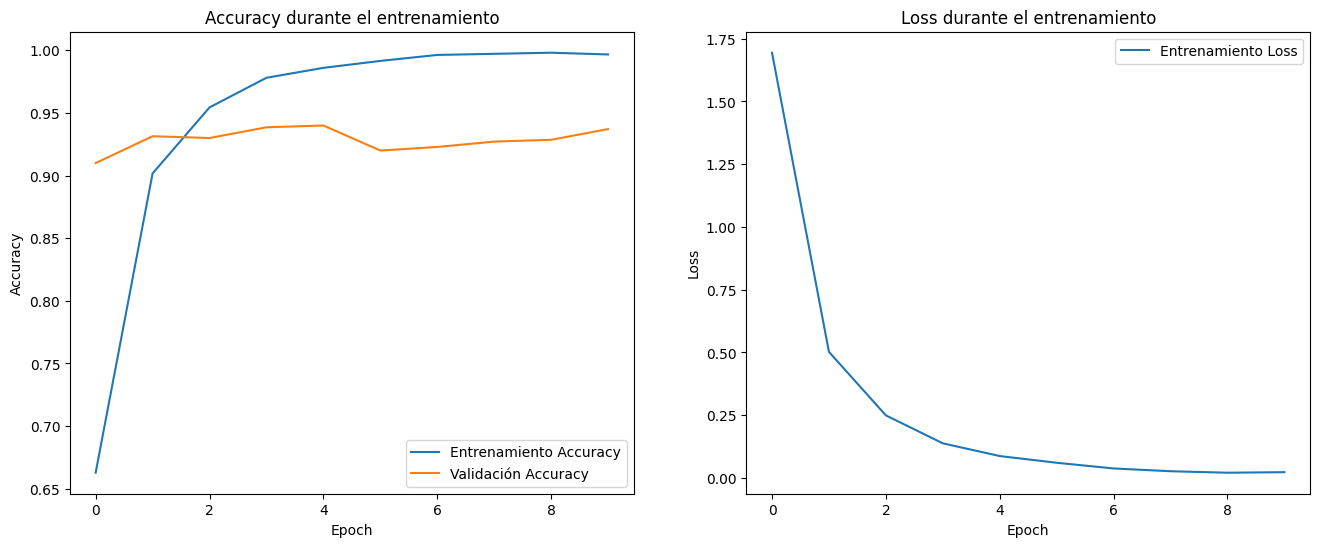

In [30]:
plt.figure(figsize=(16,6))

# Gráfico de Accuracy
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Entrenamiento Accuracy')
plt.plot(history['val_acc'], label='Validación Accuracy')
plt.legend()
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Gráfico de Loss
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Entrenamiento Loss')
plt.legend()
plt.title('Loss durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig("entrenamiento_resultados.png")
plt.show()

In [31]:
# Guardar modelo
torch.save(model.state_dict(), "modelos/resnet18_finetuned_dogbreeds.pth")

### Entrenamiento de Modelos: Modelo B (CNN)

#### Preparacion del entorno

In [32]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F

In [33]:
torch.cuda.empty_cache()
# Paths
train_dir = "train"
valid_dir = "valid"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Modelo base convolucional

In [34]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 16, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 32, 56, 56)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Entrenamiento

In [35]:
def train_manual(model, loader, optimizer, criterion):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return running_loss / len(loader), acc

In [36]:
def validate_manual(model, loader, criterion):
    model.eval()
    total, correct, running_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(loader)
    val_acc = correct / total
    return val_loss, val_acc

In [37]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [38]:
train_dataset = ImageFolder("train", transform=transform_train)
valid_dataset = ImageFolder("valid", transform=transform_valid)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8)

In [40]:
model = CustomCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(50):
    train_loss, train_acc = train_manual(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_manual(model, valid_loader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

Epoch 1: Train Loss=4.1572, Acc=0.0388 | Val Loss=4.0252, Acc=0.0543
Epoch 2: Train Loss=3.9783, Acc=0.0685 | Val Loss=3.9060, Acc=0.0771
Epoch 3: Train Loss=3.8221, Acc=0.0956 | Val Loss=3.7514, Acc=0.0914
Epoch 4: Train Loss=3.6961, Acc=0.1165 | Val Loss=3.6442, Acc=0.1257
Epoch 5: Train Loss=3.5821, Acc=0.1393 | Val Loss=3.5412, Acc=0.1386
Epoch 6: Train Loss=3.4882, Acc=0.1572 | Val Loss=3.4630, Acc=0.1629
Epoch 7: Train Loss=3.3852, Acc=0.1826 | Val Loss=3.3817, Acc=0.1714
Epoch 8: Train Loss=3.3143, Acc=0.1934 | Val Loss=3.3609, Acc=0.1914
Epoch 9: Train Loss=3.2452, Acc=0.2059 | Val Loss=3.2860, Acc=0.1857
Epoch 10: Train Loss=3.1958, Acc=0.2147 | Val Loss=3.2518, Acc=0.1986
Epoch 11: Train Loss=3.1395, Acc=0.2273 | Val Loss=3.2240, Acc=0.2300
Epoch 12: Train Loss=3.0987, Acc=0.2382 | Val Loss=3.1722, Acc=0.2186
Epoch 13: Train Loss=3.0491, Acc=0.2494 | Val Loss=3.1162, Acc=0.2400
Epoch 14: Train Loss=3.0077, Acc=0.2577 | Val Loss=3.1101, Acc=0.2371
Epoch 15: Train Loss=2.9825, 

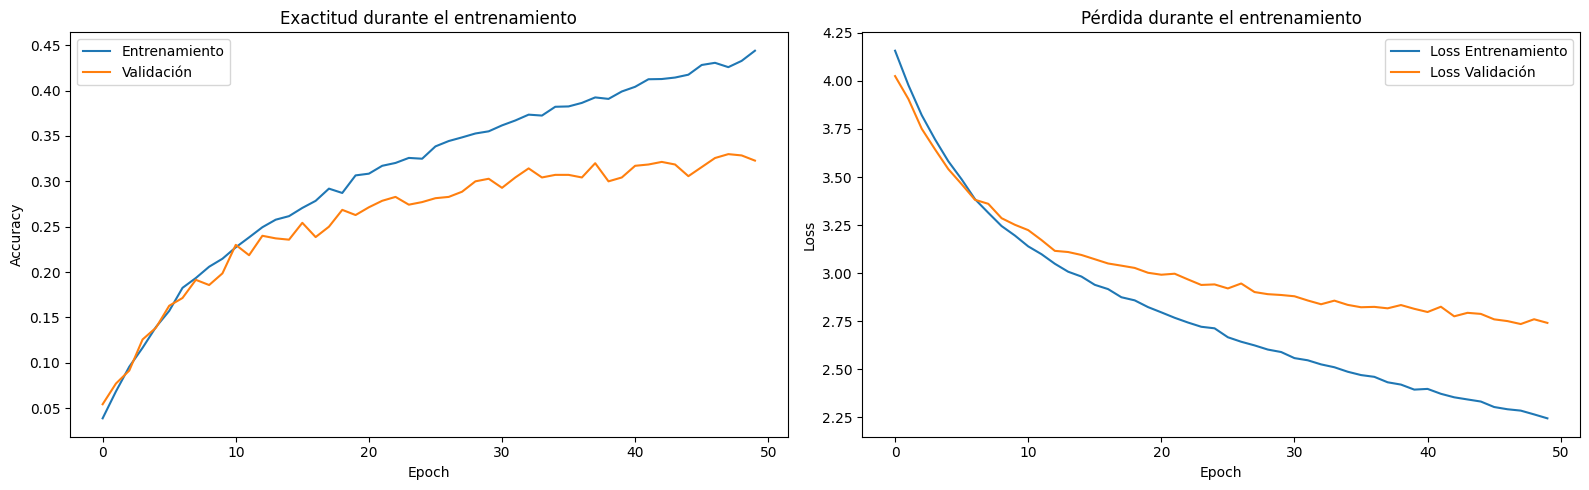

In [41]:
plt.figure(figsize=(16,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Entrenamiento')
plt.plot(history['val_acc'], label='Validación')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Loss Entrenamiento')
plt.plot(history['val_loss'], label='Loss Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("cnn_custom_resultados.png")
plt.show()

In [42]:
torch.save(model.state_dict(), "modelos/custom_cnn_dogbreeds.pth")

### Integración y Selección en la Aplicación:

#### Preparacion del entorno

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import os

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 16, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 32, 56, 56)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [48]:
model_resnet = resnet18(pretrained=False)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 70)  # 70 clases
model_resnet.load_state_dict(torch.load("modelos/resnet18_finetuned_dogbreeds.pth", map_location=device))
model_resnet.to(device).eval()

model_custom = CustomCNN()
model_custom.load_state_dict(torch.load("modelos/custom_cnn_dogbreeds.pth", map_location=device))
model_custom.to(device).eval()

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=70, bias=True)
)

#### Modelos base

In [49]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 16, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 32, 56, 56)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [45]:
def load_resnet18_feature_extractor(pth_path, num_classes=70):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(pth_path, map_location=device))
    model.eval()
    return model.to(device)

In [ ]:
def load_custom_cnn():
    model_custom = CustomCNN()
    model_custom.load_state_dict(torch.load("modelos/custom_cnn_dogbreeds.pth", map_location=device))
    model_custom = model_custom.to(device)
    return model_custom.to(device)

#### Embeddings

In [47]:
def extract_embeddings_resnet(model, loader):
    all_embeddings = []
    all_labels = []
    features = nn.Sequential(*list(model.children())[:-1]).to(device)
    features.eval()

    with torch.no_grad():
        for images, labels in loader:
            embeddings = features(images.to(device))
            embeddings = embeddings.view(embeddings.size(0), -1)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    return all_embeddings, all_labels

def extract_embeddings_custom(model_layers, loader):
    conv1, bn1, conv2, bn2, pool, dropout, fc1, fc2 = model_layers
    conv1.eval()
    bn1.eval()
    conv2.eval()
    bn2.eval()
    fc1.eval()
    fc2.eval()
    dropout.eval()
    pool.eval()

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Forward manual
            x = pool(F.relu(bn1(conv1(images))))
            x = pool(F.relu(bn2(conv2(x))))
            x = dropout(x)
            x = x.view(x.size(0), -1)
            x = F.relu(fc1(x))
            # Aquí tomamos embeddings antes de la última FC
            all_embeddings.append(x.cpu())
            all_labels.append(labels)

    embeddings = torch.cat(all_embeddings)
    labels = torch.cat(all_labels)
    return embeddings, labels

In [ ]:
if __name__ == "__main__":
    from torchvision.datasets import ImageFolder
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = ImageFolder("train", transform=transform)
    valid_dataset = ImageFolder("valid", transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    # Cargar modelos
    model_resnet = load_resnet18_feature_extractor("modelos/resnet18_finetuned_dogbreeds.pth")
    model_custom = load_custom_cnn()

    # Extraer capas para modelo custom
    conv1 = model_custom.conv1
    bn1 = model_custom.bn1
    conv2 = model_custom.conv2
    bn2 = model_custom.bn2
    pool = model_custom.pool
    dropout = model_custom.dropout
    fc1 = model_custom.fc1
    fc2 = model_custom.fc2
    model_layers = [conv1, bn1, conv2, bn2, pool, dropout, fc1, fc2]

    # Extraer embeddings
    print("Extrayendo embeddings ResNet18...")
    train_embeds_resnet, train_labels_resnet = extract_embeddings_resnet(model_resnet, train_loader)

    print("Extrayendo embeddings Custom CNN...")
    train_embeds_custom, train_labels_custom = extract_embeddings_custom(model_layers, train_loader)

    print("Listo.")

Extrayendo embeddings ResNet18...
Extrayendo embeddings Custom CNN...
Listo.


In [51]:

# Guardar embeddings ResNet
if not os.path.exists("embeddings"):
    os.makedirs("embeddings")
np.save("embeddings/train_embeds_resnet.npy", train_embeds_resnet)
np.save("embeddings/train_labels_resnet.npy", train_labels_resnet)

# Guardar embeddings Custom CNN
np.save("embeddings/train_embeds_custom.npy", train_embeds_custom)
np.save("embeddings/train_labels_custom.npy", train_labels_custom)

In [52]:
dimension_resnet = train_embeds_resnet.shape[1]  # 512
index_resnet = faiss.IndexFlatL2(dimension_resnet)
index_resnet.add(train_embeds_resnet)

In [ ]:
dimension_custom = train_embeds_custom.shape[1]  # 128
index_custom = faiss.IndexFlatL2(dimension_custom)
index_custom.add(train_embeds_custom)

In [ ]:
faiss.write_index(index_resnet, "embeddings/index_resnet.faiss")
faiss.write_index(index_custom, "embeddings/index_custom.faiss")

#### Integracion

In [44]:
def search_similar(query_embed, index, labels, paths, k=5):
    distances, indices = index.search(query_embed, k)
    results_labels = [labels[i] for i in indices[0]]
    results_paths = [paths[i] for i in indices[0]]
    return results_labels, results_paths

In [ ]:
df_train = df_dogs_breed[df_dogs_breed["data set"] == "train"].reset_index(drop=True)

train_embeds_resnet = np.load("embeddings/train_embeds_resnet.npy")
train_labels_resnet = df_train["labels"].tolist()
train_paths_resnet = df_train["full_path"].tolist()

train_embeds_custom = np.load("embeddings/train_embeds_custom.npy")
train_labels_custom = df_train["labels"].tolist()
train_paths_custom = df_train["full_path"].tolist()

index_resnet = faiss.IndexFlatL2(train_embeds_resnet.shape[1])
index_resnet.add(train_embeds_resnet)

index_custom = faiss.IndexFlatL2(train_embeds_custom.shape[1])
index_custom.add(train_embeds_custom)

In [38]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def get_embedding(image: Image.Image, model_name: str):
    x = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        if model_name == "ResNet18":
            features = nn.Sequential(*list(model_resnet.children())[:-1])
            embedding = features(x)
            embedding = embedding.view(embedding.size(0), -1)  # flatten (1,512)
        else:
            # forward parcial manual para custom CNN
            x = model_custom.pool(F.relu(model_custom.bn1(model_custom.conv1(x))))
            x = model_custom.pool(F.relu(model_custom.bn2(model_custom.conv2(x))))
            x = model_custom.dropout(x)
            x = x.view(x.size(0), -1)
            embedding = F.relu(model_custom.fc1(x))  # (1,128)
    
    return embedding.cpu().numpy()

In [ ]:
def search_and_return(image, model_name, k=10):
    embed = get_embedding(image, model_name)

    if model_name == "ResNet18":
        labels, paths = search_similar(embed, index_resnet, train_labels_resnet, train_paths_resnet, k)
    else:
        labels, paths = search_similar(embed, index_custom, train_labels_custom, train_paths_custom, k)

    predicted = Counter(labels).most_common(1)[0][0]
    return predicted, paths

In [45]:
def gradio_interface(image, model_name):
    embed = get_embedding(image, model_name)
    if model_name == "ResNet18":
        labels, paths = search_similar(embed, index_resnet, train_labels_resnet, train_paths_resnet, k=5)
    else:
        labels, paths = search_similar(embed, index_custom, train_labels_custom, train_paths_custom, k=5)
    images_with_captions = [(Image.open(p), os.path.basename(p)) for p in paths]
    return images_with_captions

iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Image(type="pil"),
        gr.Dropdown(["ResNet18", "CustomCNN"], label="Modelo a usar")
    ],
    outputs=gr.Gallery(label="Imágenes similares"),
    title="Búsqueda por similitud con dos modelos"
)

iface.launch(share=True)  # Cambiado a True para compartir la interfaz

* Running on local URL:  http://127.0.0.1:7870
* Running on public URL: https://b66053fe816675c862.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/gradio/blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/gradio/blocks.py", line 1731, in call_function
    prediction = await anyio.to_thread.run_sync(  # 

## Etapa 3: Pipeline de Detección y Clasificación en Escenas Complejas

### Deteccion de objetos

#### Preparacion del entorno

In [59]:
from ultralytics import YOLO
from PIL import ImageDraw, ImageFont
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import datasets, models

#### Modelos

In [60]:
yolo = YOLO("yolov8s.pt") # yolov8s.pt para más precisión

In [61]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 16, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 32, 56, 56)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [94]:
class DogDetector:
    def __init__(self, model_path="yolov8n.pt", conf_thres=0.5):
        self.model = YOLO(model_path)
        self.conf_thres = conf_thres
        self.dog_class_id = 16  # Clase 'dog' en COCO

    def detect(self, image_path):
        results = self.model(image_path, verbose=False)[0]
        boxes = []
        for box in results.boxes:
            cls = int(box.cls.item())
            conf = box.conf.item()
            if cls == self.dog_class_id and conf >= self.conf_thres:
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                boxes.append((x1, y1, x2, y2))
        return boxes

    def crop_dogs(self, image_path, boxes):
        image = Image.open(image_path).convert("RGB")
        return [image.crop((x1, y1, x2, y2)) for (x1, y1, x2, y2) in boxes]


In [63]:
class DogClassifier:
    def __init__(self, model_type="ResNet18", model_path=None, class_names=None):
        self.model_type = model_type
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.class_names = class_names
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        if model_type == "ResNet18":
            from torchvision.models import resnet18
            self.model = resnet18(pretrained=False)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, len(class_names))
            state_dict = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            self.model.to(self.device).eval()

        elif model_type == "Custom CNN":
            self.model = CustomCNN()
            state_dict = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            self.model.to(self.device).eval()

        else:
            raise ValueError(f"Modelo no reconocido: {model_type}")

    def classify(self, pil_image):
        x = self.transform(pil_image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(x)
            pred_idx = logits.argmax(dim=1).item()
        return self.class_names[pred_idx]

In [64]:
def mostrar_detecciones_con_etiquetas(image_path, detector, classifier):
    boxes = detector.detect(image_path)
    crops = detector.crop_dogs(image_path, boxes)
    
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)
    except:
        font = ImageFont.load_default()

    for i, (box, crop) in enumerate(zip(boxes, crops)):
        x1, y1, x2, y2 = box
        raza = classifier.classify(crop)

        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
        draw.text((x1, y1 - 20), raza, fill="white", font=font, stroke_width=1, stroke_fill="black")

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Perros detectados y clasificados")
    plt.show()

In [65]:
train_dir = "train"
valid_dir = "valid"

In [66]:
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImagenNet mean
                         [0.229, 0.224, 0.225])  # ImagenNet std
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
# Datasets y DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform_val)

#### Detector

/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/dosperros.jpg: 352x640 2 dogs, 52.4ms
Speed: 3.2ms preprocess, 52.4ms inference, 131.7ms postprocess per image at shape (1, 3, 352, 640)


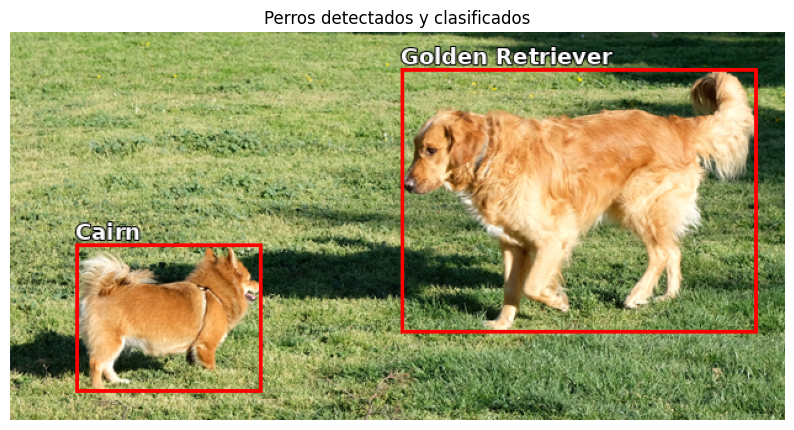

In [67]:
detector = DogDetector()

classifier_resnet = DogClassifier(
    model_type="ResNet18",
    model_path="modelos/resnet18_finetuned_dogbreeds.pth",
    class_names=train_dataset.classes
)

classifier_custom = DogClassifier(
    model_type="Custom CNN",
    model_path="modelos/custom_cnn_dogbreeds.pth",
    class_names=train_dataset.classes
)

# Ejecutar
img_path = "dosperros.jpg"
mostrar_detecciones_con_etiquetas(img_path, detector, classifier_resnet)


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/dosperros.jpg: 352x640 2 dogs, 4.8ms
Speed: 1.1ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


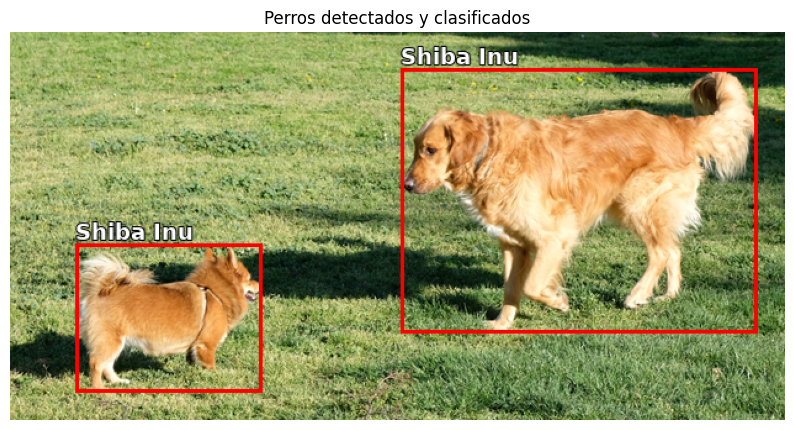

In [68]:
# Ejecutar
img_path = "dosperros.jpg"
razas = mostrar_detecciones_con_etiquetas(img_path, detector, classifier_custom)

### Creación del Pipeline Completo

In [69]:
def procesar_imagen(image_path, detector, classifier):
    boxes = detector.detect(image_path)
    crops = detector.crop_dogs(image_path, boxes)

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)
    except:
        font = ImageFont.load_default()

    for box, crop in zip(boxes, crops):
        x1, y1, x2, y2 = box
        raza = classifier.classify(crop)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
        draw.text((x1, y1 - 20), raza, fill="white", font=font, stroke_width=1, stroke_fill="black")

    return image  # Devuelve PIL.Image

In [70]:
def gradio_pipeline(input_img):
    input_img.save("temp_input.jpg")
    resultado = procesar_imagen("temp_input.jpg", detector, classifier)
    return resultado

In [71]:
# Inicializar
detector = DogDetector()
classifier = DogClassifier(
    model_type="ResNet18",
    model_path="modelos/resnet18_finetuned_dogbreeds.pth",
    class_names=train_dataset.classes
)

# Interfaz
gr.Interface(
    fn=gradio_pipeline,
    inputs=gr.Image(type="pil", label="Subí una imagen con perros"),
    outputs=gr.Image(type="pil", label="Resultado"),
    title="Clasificador de Razas de Perros con Detección YOLO + Clasificación"
).launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


## Etapa 4: Evaluación, Optimización y Herramientas de Anotación

#### Evaluación del Pipeline

In [72]:
from pycocotools.coco import COCO
from pathlib import Path
from pycocotools.cocoeval import COCOeval
import json
import pandas as pd
from ultralytics import YOLO

In [73]:
# Cargar anotaciones COCO
coco_gt = COCO("instances_default.json")

# Crear DataFrame con paths a imágenes
test_dir = "test_complex_images"
test_df = pd.DataFrame({
    'full_path': [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
})

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [74]:
test_df

full_path
0      test_complex_images/perro_caballo_nino.jpg
1             test_complex_images/perro_nieve.jpg
2             test_complex_images/perro_gato.jpeg
3  test_complex_images/perro_disfraz_caballo.jpeg
4          test_complex_images/perro_policia.jpeg
5             test_complex_images/perro_ninos.jpg
6           test_complex_images/perros_arbol.jpeg
7      test_complex_images/perro_gatos_varios.jpg
8     test_complex_images/perro_campo_ovejas.jpeg
9   test_complex_images/perro_campo_mucha_luz.jpg

In [75]:
print(coco_gt.getImgIds())
img_ids = coco_gt.getImgIds()
img_info = coco_gt.loadImgs(img_ids[0])  # o cualquier otro ID
print(img_info)
cats = coco_gt.loadCats(coco_gt.getCatIds())
for c in cats:
    print(c['id'], c['name'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[{'id': 1, 'width': 1300, 'height': 866, 'file_name': 'perro_caballo_nino.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}]
1 Dalmation
2 Border Collie
3 Golden Retriever
4 Blenheim
5 German Sheperd
6 Doberman
7 Siberian Husky
8 Labrador


In [76]:
cats = coco_gt.loadCats(coco_gt.getCatIds())
for c in cats:
    print(f"{c['id']} → {c['name']}")

1 → Dalmation
2 → Border Collie
3 → Golden Retriever
4 → Blenheim
5 → German Sheperd
6 → Doberman
7 → Siberian Husky
8 → Labrador


In [77]:
def detections_to_coco(detector, classifier, test_df, coco_gt):
    results = []

    # Mapeo de nombres de raza a category_id
    class_name_to_category_id = {
        "Dalmation": 1,
        "Border Collie": 2,
        "Golden Retriever": 3,
        "Blenheim": 4,
        "German Sheperd": 5,
        "Doberman": 6,
        "Siberian Husky": 7,
        "Labrador": 8
    }

    # Mapear nombre de archivo a image_id
    file_name_to_id = {
        img['file_name']: img['id']
        for img in coco_gt.loadImgs(coco_gt.getImgIds())
    }

    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        image_path = row['full_path']
        file_name = os.path.basename(image_path)
        image_id = file_name_to_id.get(file_name, None)
        if image_id is None:
            continue

        # Detectar perros
        pred_boxes = detector.detect(image_path)
        # Recortar cada perro detectado
        crops = detector.crop_dogs(image_path, pred_boxes)
        # Clasificar cada crop
        pred_labels = [classifier.classify(crop) for crop in crops]

        for box, class_name in zip(pred_boxes, pred_labels):
            category_id = class_name_to_category_id.get(class_name, None)
            if category_id is None:
                continue  # ignorar predicciones no reconocidas

            # Convertir [x1, y1, x2, y2] → [x, y, w, h]
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1

            results.append({
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [x1, y1, w, h],
                "score": 1.0  # o el score real si lo tenés
            })

    return results

In [ ]:
def evaluar_pipeline(detector, classifier, coco_gt, test_df):
    results = detections_to_coco(detector, classifier, test_df, coco_gt)

    with open("coco/detections.json", "w") as f:
        json.dump(results, f)

    coco_dt = coco_gt.loadRes("coco/detections.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return {
        "mAP": coco_eval.stats[0],
        "Precision@0.5": coco_eval.stats[1],
        "Recall": coco_eval.stats[8],
        "AP_medium": coco_eval.stats[4],
        "AP_large": coco_eval.stats[5],
    }

In [79]:
detector = DogDetector()
classifier = classifier_resnet  # o classifier_custom

resultados = evaluar_pipeline(detector, classifier, coco_gt, test_df)

print("Resultados:")
for k, v in resultados.items():
    print(f"{k}: {v:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_caballo_nino.jpg: 448x640 2 persons, 1 dog, 1 horse, 1 cow, 52.9ms
Speed: 1.4ms preprocess, 52.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|█         | 1/10 [00:00<00:01,  6.79it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_nieve.jpg: 448x640 1 elephant, 1 bear, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)



image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_gato.jpeg: 384x640 1 cat, 4 dogs, 57.4ms
Speed: 0.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_disfraz_caballo.jpeg: 640x384 1 person, 1 horse, 51.3ms
Speed: 0.9ms preprocess, 51.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


 40%|████      | 4/10 [00:00<00:00, 15.12it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_policia.jpeg: 352x640 1 person, 1 dog, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perros_arbol.jpeg: 640x640 2 dogs, 5.0ms
Speed: 1.8ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_gatos_varios.jpg: 480x640 3 birds, 1 cat, 5 dogs, 52.6ms
Speed: 1.6ms preprocess, 52.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 80%|████████  | 8/10 [00:00<00:00, 22.89it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_campo_ovejas.jpeg: 320x640 1 dog, 6 sheeps, 51.3ms
Speed: 1.8ms preprocess, 51.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_campo_mucha_luz.jpg: 448x640 1 sheep, 2 cows, 1 elephant, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


100%|██████████| 10/10 [00:00<00:00, 13.46it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

### Optimización de Modelos

#### Exportación a formato optimizado

In [80]:
from torchvision.models import resnet18
import onnxruntime as ort
import onnx
import numpy as np

In [81]:
# Cargar el modelo entrenado (ajustá el path si es distinto)
model = resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 70)  # 70 clases de razas

/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [82]:
# Cargar pesos
state_dict = torch.load("modelos/resnet18_finetuned_dogbreeds.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()  # Importante: eval mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
# Crear dummy input
dummy_input = torch.randn(1, 3, 224, 224)

In [84]:
# Exportar a ONNX
torch.onnx.export(
    model,
    dummy_input,
    "dog_classifier_resnet18.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print("✅ Modelo exportado a 'dog_classifier_resnet18.onnx'")

✅ Modelo exportado a 'dog_classifier_resnet18.onnx'


In [85]:
session = ort.InferenceSession("resnet18_dogbreeds_70classes.onnx")
input_data = np.random.randn(1, 3, 224, 224).astype(np.float32)

output = session.run(None, {"input": input_data})
print("Predicción ONNX:", output[0].shape)  # Debería ser (1, 70)

onnx_model = onnx.load("dog_classifier_resnet18.onnx")
onnx.checker.check_model(onnx_model)
print("✅ El modelo ONNX es válido.")

Predicción ONNX: (1, 70)
✅ El modelo ONNX es válido.


In [86]:
# Transformaciones (mismo preprocessing que en entrenamiento)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = train_dataset.classes

# Cargar imagen y preprocesar
image = Image.open("test/Afghan/01.jpg").convert("RGB")
input_tensor = transform(image).unsqueeze(0).numpy()

# Cargar modelo ONNX con ONNX Runtime
session = ort.InferenceSession("dog_classifier_resnet18.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Inferencia
outputs = session.run([output_name], {input_name: input_tensor})
pred = np.argmax(outputs[0])
print("🐶 Clase predicha:", class_names[pred])

🐶 Clase predicha: Afghan


### Script de Anotación Automática:

In [87]:
import torchvision.transforms as transforms
import torch
import os
import json
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Configuraciones
input_folder = "test"
output_yolo = "labels_yolo"
output_coco = "coco/output_annotations_coco.json"

#### Modelos

In [96]:
# Cargar modelos
detector = DogDetector()
classifier = DogClassifier(
    model_type="ResNet18",
    model_path="modelos/resnet18_finetuned_dogbreeds.pth",
    class_names = train_dataset.classes
)

/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [90]:
# Inicializar COCO
coco_dict = {
    "info": {"description": "Anotaciones automáticas"},
    "images": [],
    "annotations": [],
    "categories": [{"id": i+1, "name": name} for i, name in enumerate(classifier.class_names)]
}

annotation_id = 1

In [92]:
df_dogs_breed

filepaths  labels data set  \
0     train/Afghan/001.jpg  Afghan    train   
1     train/Afghan/002.jpg  Afghan    train   
2     train/Afghan/003.jpg  Afghan    train   
3     train/Afghan/004.jpg  Afghan    train   
4     train/Afghan/005.jpg  Afghan    train   
...                    ...     ...      ...   
9341   valid/Yorkie/06.jpg  Yorkie    valid   
9342   valid/Yorkie/07.jpg  Yorkie    valid   
9343   valid/Yorkie/08.jpg  Yorkie    valid   
9344   valid/Yorkie/09.jpg  Yorkie    valid   
9345   valid/Yorkie/10.jpg  Yorkie    valid   

                                              full_path  
0     /home/franco/Escritorio/TUIA/Computer Vision/C...  
1     /home/franco/Escritorio/TUIA/Computer Vision/C...  
2     /home/franco/Escritorio/TUIA/Computer Vision/C...  
3     /home/franco/Escritorio/TUIA/Computer Vision/C...  
4     /home/franco/Escritorio/TUIA/Computer Vision/C...  
...                                                 ...  
9341  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9342  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9343  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9344  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9345  /home/franco/Escritorio/TUIA/Computer Vision/C...  

[9346 rows x 4 columns]

In [97]:
# Filtrar solo las imágenes del conjunto 'test'
df_test = df_dogs_breed[df_dogs_breed['data set'] == 'test']

for image_id, row in tqdm(df_test.iterrows(), total=len(df_test)):
    img_path = row['full_path']
    image_name = os.path.basename(img_path)

    image = Image.open(img_path).convert("RGB")
    boxes = detector.detect(img_path)
    crops = detector.crop_dogs(img_path, boxes)

    coco_dict["images"].append({
        "id": image_id,
        "file_name": image_name,
        "width": image.width,
        "height": image.height
    })

    with open(os.path.join(output_yolo, Path(image_name).stem + ".txt"), "w") as yolo_file:
        for box, crop in zip(boxes, crops):
            x1, y1, x2, y2 = box
            raza = classifier.classify(crop)
            class_id = classifier.class_names.index(raza)

            # Formato YOLOv5
            x_center = (x1 + x2) / 2 / image.width
            y_center = (y1 + y2) / 2 / image.height
            width = (x2 - x1) / image.width
            height = (y2 - y1) / image.height
            yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

            # Formato COCO
            coco_dict["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": class_id + 1,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "area": (x2 - x1) * (y2 - y1),
                "iscrowd": 0
            })
            annotation_id += 1


100%|██████████| 700/700 [00:06<00:00, 102.76it/s]
